In [1]:
import matplotlib.pyplot
from tqdm import tqdm
import torch

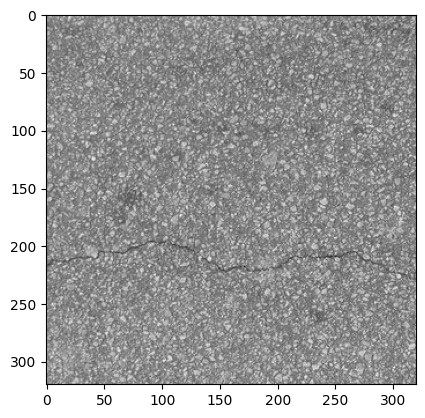

In [2]:
import cv2
import os
import matplotlib.pyplot as plt

img_path = "/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image/4_039.png"
label_path = "/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/annotations/4_039.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


In [3]:
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet101
from sklearn.metrics import jaccard_score
import numpy as np

In [4]:
src_image = "/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image"
src_mask = "/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label"
val_image = "/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image"
val_mask = "/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label"

image_dir = "/kaggle/working/images"
mask_dir = "/kaggle/working/masks"
val_img_dir = "/kaggle/working/val_images"
val_mask_dir = "/kaggle/working/val_masks"

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

for f in os.listdir(src_image):
    shutil.copy(os.path.join(src_image, f), os.path.join(image_dir, f))
for f in os.listdir(src_mask):
    shutil.copy(os.path.join(src_mask, f), os.path.join(mask_dir, f))
for f in os.listdir(val_image):
    shutil.copy(os.path.join(val_image, f), os.path.join(val_img_dir, f))
for f in os.listdir(val_mask):
    shutil.copy(os.path.join(val_mask, f), os.path.join(val_mask_dir, f))

In [5]:
class RoadCrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        return image, mask

In [6]:
def get_deeplab_model_from_torch(pretrained=False, lr = 1e-4):
    model = deeplabv3_resnet50(weights="DEFAULT" if pretrained else None)
    model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=1)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    return model, optimizer

In [7]:
class EarlyStopping:
    def __init__(self, patience=20, delta=0.001, mode='max'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif (self.mode == 'max' and score < self.best_score + self.delta) or \
             (self.mode == 'min' and score > self.best_score - self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [8]:
def compute_iou(preds, targets):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    preds_np = preds.cpu().numpy().reshape(-1)
    targets_np = targets.cpu().numpy().reshape(-1)

    return jaccard_score(targets_np, preds_np, zero_division=0)

In [9]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

train_dataset = RoadCrackDataset(image_dir, mask_dir, transform=transform)
val_dataset = RoadCrackDataset(val_img_dir, val_mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, optimizer = get_deeplab_model_from_torch(pretrained=True, lr=1e-4)
model = model.to(device)

early_stopping = EarlyStopping(patience=20,delta = 0.001, mode='max')

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 198MB/s]  


In [10]:
model = torch.nn.DataParallel(model)

In [11]:
for epoch in range(200):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        out = model(images)["out"]
        loss = F.binary_cross_entropy_with_logits(out, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_iou_total = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            out = model(images)["out"]
            val_iou_total += compute_iou(out, masks)
    val_iou_avg = val_iou_total / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val IoU: {val_iou_avg:.4f}")

    early_stopping(val_iou_avg)
    if early_stopping.early_stop:
        print("OH SHIET!! Early stopping triggered!!")
        break

Epoch 1, Train Loss: 112.6001, Val IoU: 0.1532
Epoch 2, Train Loss: 45.6283, Val IoU: 0.3238
Epoch 3, Train Loss: 34.3927, Val IoU: 0.3281
Epoch 4, Train Loss: 29.2881, Val IoU: 0.2743
Epoch 5, Train Loss: 26.4195, Val IoU: 0.2847
Epoch 6, Train Loss: 24.5151, Val IoU: 0.2588
Epoch 7, Train Loss: 24.1189, Val IoU: 0.2561
Epoch 8, Train Loss: 22.5622, Val IoU: 0.3291
Epoch 9, Train Loss: 21.4335, Val IoU: 0.3897
Epoch 10, Train Loss: 22.1426, Val IoU: 0.4020
Epoch 11, Train Loss: 22.6361, Val IoU: 0.2784
Epoch 12, Train Loss: 22.8871, Val IoU: 0.2782
Epoch 13, Train Loss: 21.2736, Val IoU: 0.3336
Epoch 14, Train Loss: 19.6363, Val IoU: 0.3411
Epoch 15, Train Loss: 19.4681, Val IoU: 0.3720
Epoch 16, Train Loss: 19.2965, Val IoU: 0.3703
Epoch 17, Train Loss: 19.0087, Val IoU: 0.3605
Epoch 18, Train Loss: 18.1353, Val IoU: 0.3912
Epoch 19, Train Loss: 17.2730, Val IoU: 0.2971
Epoch 20, Train Loss: 16.5343, Val IoU: 0.3709
Epoch 21, Train Loss: 16.0987, Val IoU: 0.3959
Epoch 22, Train Loss:

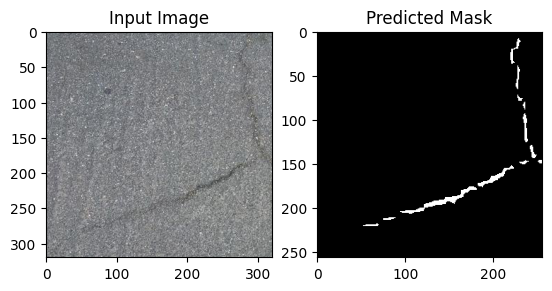

In [12]:
test_image = Image.open("/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/test/image/1_006.png").convert("RGB")
test_tensor = transform(test_image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(test_tensor)["out"]
    pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype("uint8") * 255

plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()